# Extract and work with stimulated/inhibited cells and the rest

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from postgres_analysis_helpers.get_data import *
from postgres_analysis_helpers.circstat_functions import *
# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General
Loaded postgres_analysis_helpers -> general
Loaded postgres_analysis_helpers -> get_data
Loaded postgres_analysis_helpers -> circstat_functions


In [2]:
# Database connection check
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Woot! Database connection is established!')

Connecting to the PostgreSQL database...
Woot! Database connection is established!


### Connect to the database 

In [3]:
stimulus_stats = pd.DataFrame() # create empty dataframe or feed in a base dataframe from before! 
psql = psql_neuroballs(stimulus_stats) # initialize retrieval

84 animals across 5 experimenters found.
Total # of sessions: 9280 (unique clusters: 16405)


**First retrieve all stimulus stats**. That means that only cells for which stimulus sessions were actually run are included in this retrieval step. No baseline sessions are present - only the laser sessions.
This is because the `stimulus_tb` table only contains laser stimulus session information - nothing else! 

In [4]:
dict_ = {'stimulus_tb': ''}
animals_ = ['74470','74471','74933','74935','74472','74473','74956','73358','73359']
filter_ = "AND session_name NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"
stimulus_stats = psql.retrieve_data(dict_,animals_,filter_)

10446 entries retrieved.


### Set parameters

In [5]:
# Set parameters:
# excitation:
salt_i_thresh = 0.09
salt_p_thresh = 0.05
min_number_sessions = 2 # min number of session for which criteria above have to be fullfilled
pearson_r_thresh = 0.99 # waveform similarity cutoff

# ISI contamination (%)
isi_contam_thresh = 1

# inhibition:
p_inhib_thresh = 0.001 # inhibition threshold
inhib_interval_ = 10 # Interval to filter for - to get rid of spurious results (blanking artefacts) 
# ISI contamination (%)
isi_contam_thresh = 1


### Loop over stimulus stats write label

In [6]:
labels_excited_ = []
labels_inhibited_ = []

for i in tqdm_notebook(range(len(stimulus_stats))):
   
    if (stimulus_stats.iloc[i].salt_i >= salt_i_thresh) and (stimulus_stats.iloc[i].salt_p < salt_p_thresh):
        labels_excited_.append('excited')
    else:
        labels_excited_.append('not_excited')
    ######################################################################
    if (stimulus_stats.iloc[i].inhib_lowest_p < p_inhib_thresh) and (stimulus_stats.iloc[i].inhib_lowest_p_interval > inhib_interval_) and \
                                (stimulus_stats.iloc[i].inhibited == True):
        labels_inhibited_.append('inhibited')
    else:
        labels_inhibited_.append('not_inhibited')
    ######################################################################
        
stimulus_stats['excited_'] = labels_excited_
stimulus_stats['inhibited_'] = labels_inhibited_

HBox(children=(IntProgress(value=0, max=9317), HTML(value='')))

### Extract excited / inhibited -> sort

In [7]:
excited_cells = stimulus_stats[stimulus_stats['excited_'] == 'excited'].reset_index(drop=True)
excited_cells.sort_values(by='salt_i',ascending=False,inplace=True)
excited_cells.reset_index(inplace=True,drop=True)

inhibited_cells = stimulus_stats[stimulus_stats['inhibited_'] == 'inhibited'].reset_index(drop=True)
inhibited_cells.sort_values(by='inhib_lowest_p',ascending=True,inplace=True)
inhibited_cells.reset_index(inplace=True,drop=True)

rest_cells = stimulus_stats[(stimulus_stats['inhibited_'] == 'not_inhibited') &\
                           (stimulus_stats['excited_'] == 'not_excited')].reset_index(drop=True)
rest_cells.reset_index(inplace=True,drop=True)

### Count sessions and filter for session number (drop duplicates)

In [8]:
# Excited cells:
drop_subgroup_excited = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','excited_','filename']
drop_subgroup_inhibited = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','inhibited_','filename']
drop_subgroup_rest = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','filename']

no_sessions_excited_cells = excited_cells.groupby(drop_subgroup_excited).size().reset_index().copy()
excited_cells_sessions = excited_cells.drop_duplicates(drop_subgroup_excited).sort_values(by=drop_subgroup_excited).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_excited_cells.animal_id.values == excited_cells_sessions.animal_id.values).all() != True) or ((no_sessions_excited_cells.cluster_no.values == excited_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()
excited_cells_sessions['no_sessions'] = no_sessions_excited_cells.iloc[:,-1].values

# Inhibited cells:
no_sessions_inhibited_cells = inhibited_cells.groupby(drop_subgroup_inhibited).size().reset_index().copy()
inhibited_cells_sessions = inhibited_cells.drop_duplicates(drop_subgroup_inhibited).sort_values(by=drop_subgroup_inhibited).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_inhibited_cells.animal_id.values == inhibited_cells_sessions.animal_id.values).all() != True) or ((no_sessions_inhibited_cells.cluster_no.values == inhibited_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()
inhibited_cells_sessions['no_sessions'] = no_sessions_inhibited_cells.iloc[:,-1].values

# Rest of cells:
no_sessions_rest_cells = rest_cells.groupby(drop_subgroup_rest).size().reset_index().copy()
rest_cells_sessions = rest_cells.drop_duplicates(drop_subgroup_rest).sort_values(by=drop_subgroup_rest).reset_index().copy()

# Quick sanity check (both have to be true)
if ((no_sessions_rest_cells.animal_id.values == rest_cells_sessions.animal_id.values).all() != True) or ((no_sessions_rest_cells.cluster_no.values == rest_cells_sessions.cluster_no.values).all() != True): 
    print('DATAFRAMES DO NOT MATCH!'); sys.exit()
    
rest_cells_sessions['no_sessions'] = no_sessions_rest_cells.iloc[:,-1].values

### Change label on excited and inhibited cells according to session count

In [9]:
labels_ = []
for i in range(len(excited_cells_sessions)):
    if excited_cells_sessions.iloc[i].no_sessions < min_number_sessions:
        labels_.append('not_excited')
    else:
        labels_.append('excited')
excited_cells_sessions['excited_'] = labels_ 

labels_ = []
for i in range(len(inhibited_cells_sessions)):
    if inhibited_cells_sessions.iloc[i].no_sessions < min_number_sessions:
        labels_.append('not_inhibited')
    else:
        labels_.append('inhibited')
inhibited_cells_sessions['inhibited_'] = labels_ 

In [10]:
# overwrite original dfs. 
excited_cells = excited_cells_sessions.copy()
inhibited_cells = inhibited_cells_sessions.copy()
rest_cells = rest_cells_sessions.copy()

### Get waveforms (laser sessions)

In [11]:
psql = psql_neuroballs(excited_cells) # initialize retrieval
dict_ = {'waveforms_tb':'mean_wf'}
excited_cells = psql.retrieve_data(dict_)

psql = psql_neuroballs(inhibited_cells) # initialize retrieval
dict_ = {'waveforms_tb':'mean_wf'}
inhibited_cells = psql.retrieve_data(dict_)

Length of input dataframe: 182
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=182), HTML(value='')))

Success. NaNs: 27

Length of input dataframe: 452
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=452), HTML(value='')))

Success. NaNs: 34



In [12]:
excited_cells.rename(columns={'mean_wf':'mean_wf_laser','session_name':'session_name_laser'}, inplace=True) # rename the waveform column - "tag" with laser
inhibited_cells.rename(columns={'mean_wf':'mean_wf_laser','session_name':'session_name_laser'}, inplace=True) 
rest_cells.rename(columns={'session_name':'session_name_laser'}, inplace=True)

### Retrieve baseline waveforms and ISI for excited cells

In [13]:
dict_ = {'waveforms_tb':'mean_wf','ISI_tb':'ISI_stats_contam_perc'}
filter_ = "NOT LIKE '%las%' AND session_name NOT LIKE '%obj%' AND session_name NOT LIKE '%stab%' AND session_name NOT LIKE '%room%' AND session_name NOT LIKE '%bord%'"

psql = psql_neuroballs(excited_cells) # initialize retrieval
excited_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

psql = psql_neuroballs(inhibited_cells) # initialize retrieval
inhibited_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

dict_ = {'ISI_tb':'ISI_stats_contam_perc'}
psql = psql_neuroballs(rest_cells) # initialize retrieval
rest_cells = psql.retrieve_data(user_sql_tables=dict_,user_sql_filter=filter_)

Length of input dataframe: 182
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=182), HTML(value='')))

Success. NaNs: 5


HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=182), HTML(value='')))

Success. NaNs: 12

Length of input dataframe: 452
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='waveforms_tb: ', max=452), HTML(value='')))

Success. NaNs: 4


HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=454), HTML(value='')))

Success. NaNs: 6

Length of input dataframe: 1823
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='ISI_tb: ', max=1823), HTML(value='')))

Success. NaNs: 29



In [14]:
# get rid of duplicates
drop_subgroup = ['animal_id','n_drive_user','session_ts','cluster_no','tetrode_no','excited_','inhibited_','filename']
inhibited_cells = inhibited_cells.drop_duplicates(drop_subgroup).reset_index().copy()
excited_cells = excited_cells.drop_duplicates(drop_subgroup).reset_index().copy()
rest_cells = rest_cells.drop_duplicates(drop_subgroup).reset_index().copy()

### Drop nans (careful! these cells will not appear anymore!) 

In [15]:
excited_cells.dropna(subset=['mean_wf','mean_wf_laser','isi_stats_contam_perc'],inplace=True)
inhibited_cells.dropna(subset=['mean_wf','mean_wf_laser','isi_stats_contam_perc'],inplace=True)
rest_cells.dropna(subset=['isi_stats_contam_perc'],inplace=True) # for rest cells only get rid of isi contaminations

### Rest of the cells: get rid of ISI contaminated cells

In [16]:
inhibited_cells = inhibited_cells[inhibited_cells.isi_stats_contam_perc < isi_contam_thresh].copy()
excited_cells = excited_cells[excited_cells.isi_stats_contam_perc < isi_contam_thresh].copy()
rest_cells = rest_cells[rest_cells.isi_stats_contam_perc < isi_contam_thresh].copy()

### Calculate pearson's R between waveforms 

In [17]:
#sns.set(font_scale=2.2,style='white')
#
#wf_r,wf_p = corr_wf_base_laser(excited_cells.sort_values(by='salt_i',ascending=False)[:5], 'mean_wf', 'mean_wf_laser', plotting=True)
#labels_exc_ = []
#labels_inhib_ = []
#for i in range(len(excited_cells)):
#    if wf_r[i] < pearson_r_thresh:   
#        labels_exc_.append('not_excited')
#        labels_inhib_.append('not_inhibited')
#    else:
#        labels_exc_.append(excited_cells.iloc[i].excited_)
#        labels_inhib_.append(excited_cells.iloc[i].inhibited_)
#excited_cells['excited_'] = labels_exc_   
#excited_cells['inhibited_'] = labels_inhib_ 

In [18]:
wf_r,wf_p = corr_wf_base_laser(excited_cells, 'mean_wf', 'mean_wf_laser', plotting=False)
labels_exc_ = []
labels_inhib_ = []
for i in range(len(excited_cells)):
    if wf_r[i] < pearson_r_thresh:   
        labels_exc_.append('not_excited')
        labels_inhib_.append('not_inhibited')
    else:
        labels_exc_.append(excited_cells.iloc[i].excited_)
        labels_inhib_.append(excited_cells.iloc[i].inhibited_)
excited_cells['excited_'] = labels_exc_   
excited_cells['inhibited_'] = labels_inhib_   
        
wf_r,wf_p = corr_wf_base_laser(inhibited_cells, 'mean_wf', 'mean_wf_laser', plotting=False)
labels_exc_ = []
labels_inhib_ = []
for i in range(len(inhibited_cells)):
    if wf_r[i] < pearson_r_thresh:   
        labels_exc_.append('not_excited')
        labels_inhib_.append('not_inhibited')
    else:
        labels_exc_.append(inhibited_cells.iloc[i].excited_)
        labels_inhib_.append(inhibited_cells.iloc[i].inhibited_)

inhibited_cells['excited_'] = labels_exc_   
inhibited_cells['inhibited_'] = labels_inhib_   

C:\Users\horsto\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\horsto\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\horsto\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [19]:
# Sort again - why not ... 
excited_cells.sort_values(by='salt_i',ascending=False,inplace=True)
inhibited_cells.sort_values(by='inhib_lowest_p',ascending=True,inplace=True)

### Snippets of every dataframe

In [20]:
columns_to_keep = ['animal_id','n_drive_user','filename','session_ts','session_name','session_name_laser','tetrode_no','cluster_no','excited_','inhibited_']

In [21]:
# double labeled cells

In [22]:
excited_cells[(excited_cells.excited_ == 'excited') & (excited_cells.inhibited_ == 'inhibited')][columns_to_keep]

,animal_id,n_drive_user,filename,session_ts,session_name,session_name_laser,tetrode_no,cluster_no,excited_,inhibited_
79,74470,horsto,L:/horsto/74470/06102017/KLUSTA/0.kwik,2017-10-06 16:49:02,06102017s1,06102017laser4(35mW)s1,5,38,excited,inhibited


In [23]:
inhibited_cells[(inhibited_cells.excited_ == 'excited') & (inhibited_cells.inhibited_ == 'inhibited')][columns_to_keep]

,animal_id,n_drive_user,filename,session_ts,session_name,session_name_laser,tetrode_no,cluster_no,excited_,inhibited_
157,74470,horsto,L:/horsto/74470/03102017/KLUSTA/3.kwik,2017-10-03 16:13:41,03102017s1,03102017laser3(50mW)s1,8,37,excited,inhibited
164,74470,horsto,L:/horsto/74470/06102017/KLUSTA/0.kwik,2017-10-06 16:49:02,06102017s1,06102017laser3(30mW)s1,5,38,excited,inhibited
79,74470,horsto,N:/horsto/74470/08092017/KLUSTA/1.kwik,2017-09-08 13:30:23,08092017s1,08092017laser4(3mW)s1,6,36,excited,inhibited


### Combine the dataframes into one

In [24]:
excited_cells_ = excited_cells[excited_cells.excited_ == 'excited'][columns_to_keep].copy()
excited_cells_rest = excited_cells[excited_cells.excited_ == 'not_excited'][columns_to_keep].copy()

inhibited_cells_ = inhibited_cells[inhibited_cells.inhibited_ == 'inhibited'][columns_to_keep].copy()
inhibited_cells_rest = inhibited_cells[inhibited_cells.inhibited_ == 'not_inhibited'][columns_to_keep].copy()

columns_for_drop = ['animal_id','n_drive_user','filename','session_ts','tetrode_no','cluster_no']
excited_cells_.drop_duplicates(subset=columns_for_drop,inplace=True)
inhibited_cells_.drop_duplicates(subset=columns_for_drop,inplace=True)

In [25]:
excited_inhibited = pd.concat([excited_cells_,inhibited_cells_],ignore_index=True)

In [26]:
# First look at the excited and inhibited cells - find double labels
labels_ = []
for i in range(len(excited_inhibited)):
    if excited_inhibited.duplicated(subset=columns_for_drop,keep=False).iloc[i] == True:
        labels_.append('both')
    elif excited_inhibited.iloc[i].excited_ == 'excited':
        labels_.append('excited')
    elif excited_inhibited.iloc[i].inhibited_ == 'inhibited':
        labels_.append('inhibited')
    else:
        print('wtf dude!')
        
excited_inhibited['label'] = labels_

In [27]:
rest_cells = rest_cells[columns_to_keep].copy()
all_data_rest = pd.concat([rest_cells,excited_cells_rest,inhibited_cells_rest],ignore_index=True)

In [28]:
labels_ = []
for i in range(len(all_data_rest)):
    if all_data_rest.iloc[i].excited_ == 'not_excited':
        labels_.append('rest')
    elif all_data_rest.iloc[i].inhibited_ == 'not_inhibited':
        labels_.append('rest')
    else:
        print('wtf dude!')
        
all_data_rest['label'] = labels_

In [29]:
# Concatenate all 
all_ = pd.concat([excited_inhibited,all_data_rest])

In [30]:
all_.sort_values(by='label',ascending=True,inplace=True)
# THIS SORTING STEP IS IMPORTANT: this way, "both" comes first and is maintained when duplicates are dropped
columns_for_drop = ['animal_id','n_drive_user','filename','session_ts','tetrode_no','cluster_no']
all_ = all_.drop_duplicates(subset=columns_for_drop).copy()

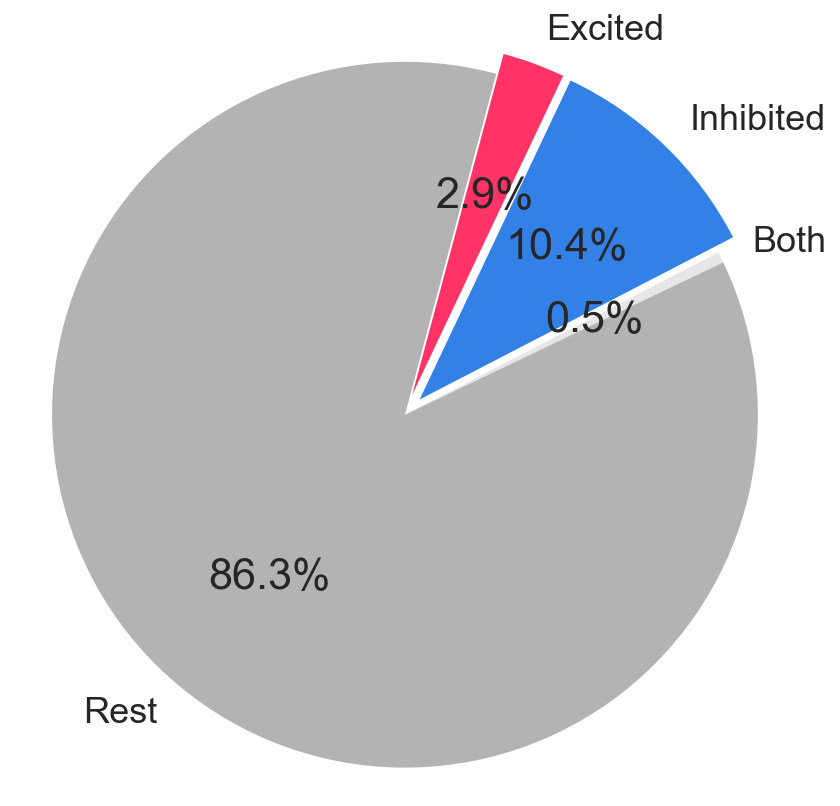

In [31]:
sns.set(font_scale=1.8)
labels = 'Excited', 'Inhibited', 'Both', 'Rest'
sizes = [len(all_[all_.label == 'excited']),\
          len(all_[all_.label == 'inhibited']),\
              len(all_[all_.label == 'both']),\
                len(all_[all_.label == 'rest'])]
explode = (.06,.06,0,0)  

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=75,counterclock=False,colors=[[1,.2,.4],[.2,.5,.9],[.9,.9,.9],[.7,.7,.7]])
ax1.axis('equal') 
plt.show()

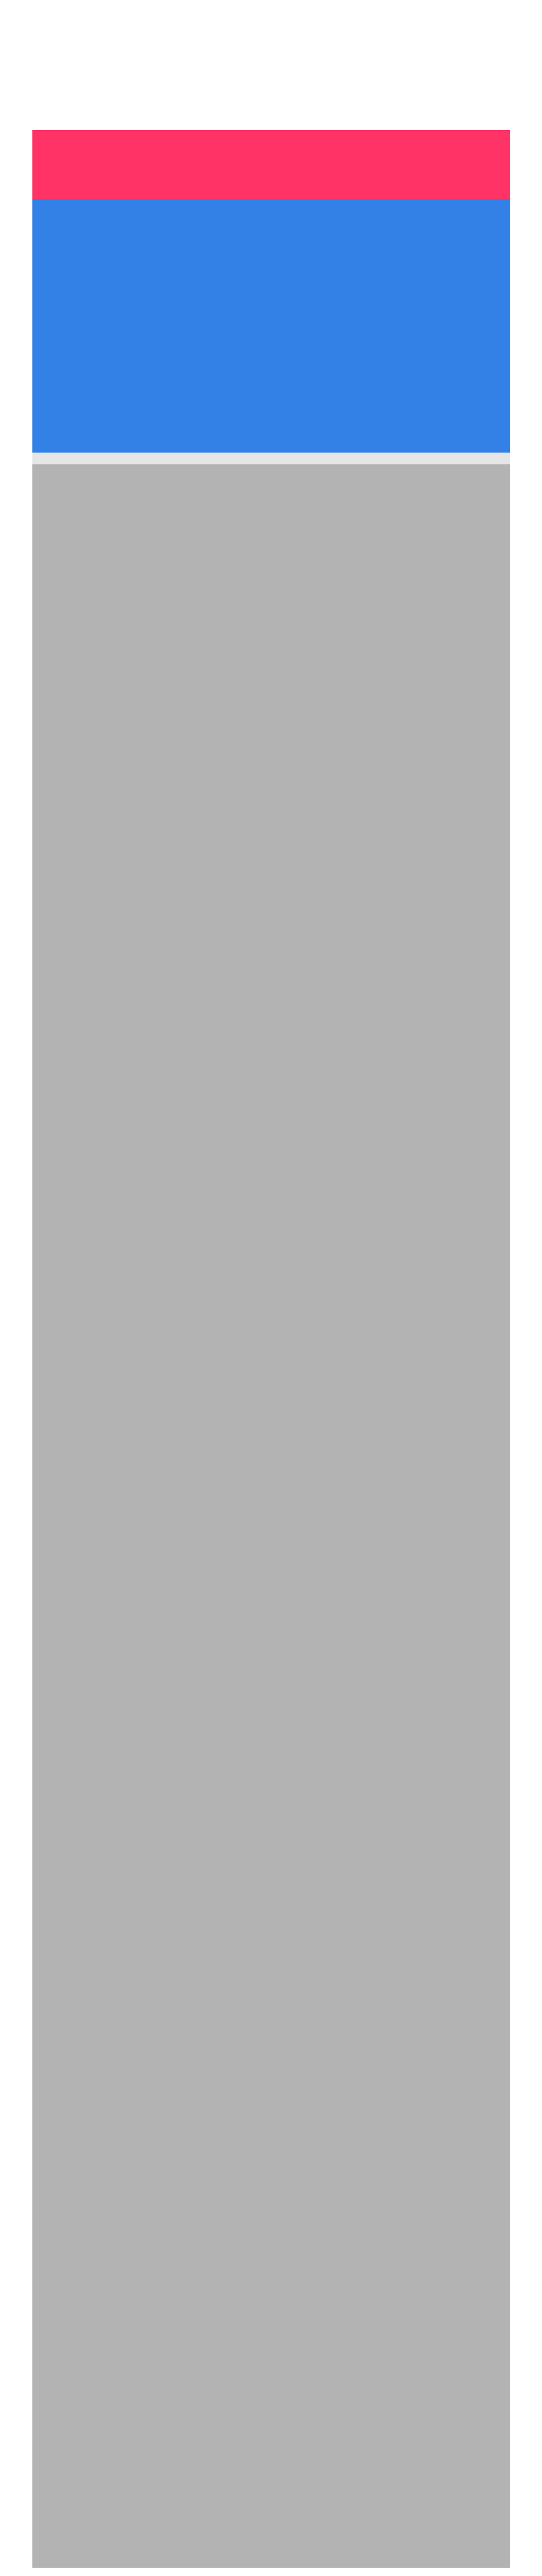

In [32]:
sns.set(font_scale=5.5,style='white')
plt.figure(figsize=(8,40))
excited_ = len(all_[all_.label == 'excited'])
inhibited_ = len(all_[all_.label == 'inhibited'])
both_ = len(all_[all_.label == 'both'])
rest_ = len(all_[all_.label == 'rest'])

ind = 1    # the x locations for the groups
width = 0.55       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, excited_, width, color=[1,.2,.4],
            bottom=inhibited_+both_+rest_)
p2 = plt.bar(ind, inhibited_, width, color=[.2,.5,.9],
             bottom=both_+rest_)
p3 = plt.bar(ind, both_, width,color=[.9,.9,.9],
             bottom=rest_)
p4 = plt.bar(ind, rest_, width,color=[.7,.7,.7])

#plt.ylabel('Number of cells')
plt.xticks()
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Excited', 'Inhibited'))
frame1 = plt.gca()
frame1.get_xaxis().set_ticks([])
frame1.get_yaxis().set_ticks([])

sns.despine(left=True,bottom=True)
plt.show()

In [33]:
print('Summary')
print('Excited       {}'.format(len(all_[all_.label == 'excited'])))
print('Inhibited     {}'.format(len(all_[all_.label == 'inhibited'])))
print('Both          {}'.format(len(all_[all_.label == 'both'])))
print('Rest          {}'.format(len(all_[all_.label == 'rest'])))
print('Sum           {}'.format(len(all_[all_.label == 'rest'])+len(all_[all_.label == 'excited'])+len(all_[all_.label == 'inhibited'])+len(all_[all_.label == 'both'])))

Summary
Excited       52
Inhibited     188
Both          9
Rest          1565
Sum           1814


### Rename and clean

In [34]:
all_.rename(columns={'session_name':'session_name_base','session_name_laser':'session_name'}, inplace=True)

### SAVE!

In [35]:
all_.to_pickle('dataframe_export/all_cells.pkl')

### Draw some stuff ... 

In [36]:
psql = psql_neuroballs(all_[all_.label == 'excited'])
dict_ = {'stimulus_tb':'','stimulus_mat_tb':''}
data_to_draw = psql.retrieve_data(dict_)

Length of input dataframe: 52
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'analysis_window', 'salt_window', 'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq', 'stim_length', 'counter_stimuli', 'excited', 'salt_p', 'salt_i', 'ex_latency_mean', 'ex_latency_median', 'ex_latency_var', 'ex_latency_reliabil', 'stats_p_inhib_10', 'stats_p_inhib_20', 'stats_p_inhib_30', 'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p', 'inhib_lowest_p_interval', 'change_point_ms')
Column filename already exists. Skipping.


HBox(children=(IntProgress(value=0, description='stimulus_tb: ', max=52), HTML(value='')))

Success. NaNs: 0
Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'sample_rate', 'sample_rate_inp', 'analysis_window', 'counter_stimuli', 'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms', 'bin_edges_1ms', 'binnumber_1ms')
Column analysis_ts already exists. Skipping.
Column filename already exists. Skipping.
Column sample_rate already exists. Skipping.
Column sample_rate_inp already exists. Skipping.
Column analysis_window already exists. Skipping.
Column counter_stimuli already exists. Skipping.


HBox(children=(IntProgress(value=0, description='stimulus_mat_tb: ', max=52), HTML(value='')))

Success. NaNs: 0



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Generating plot...


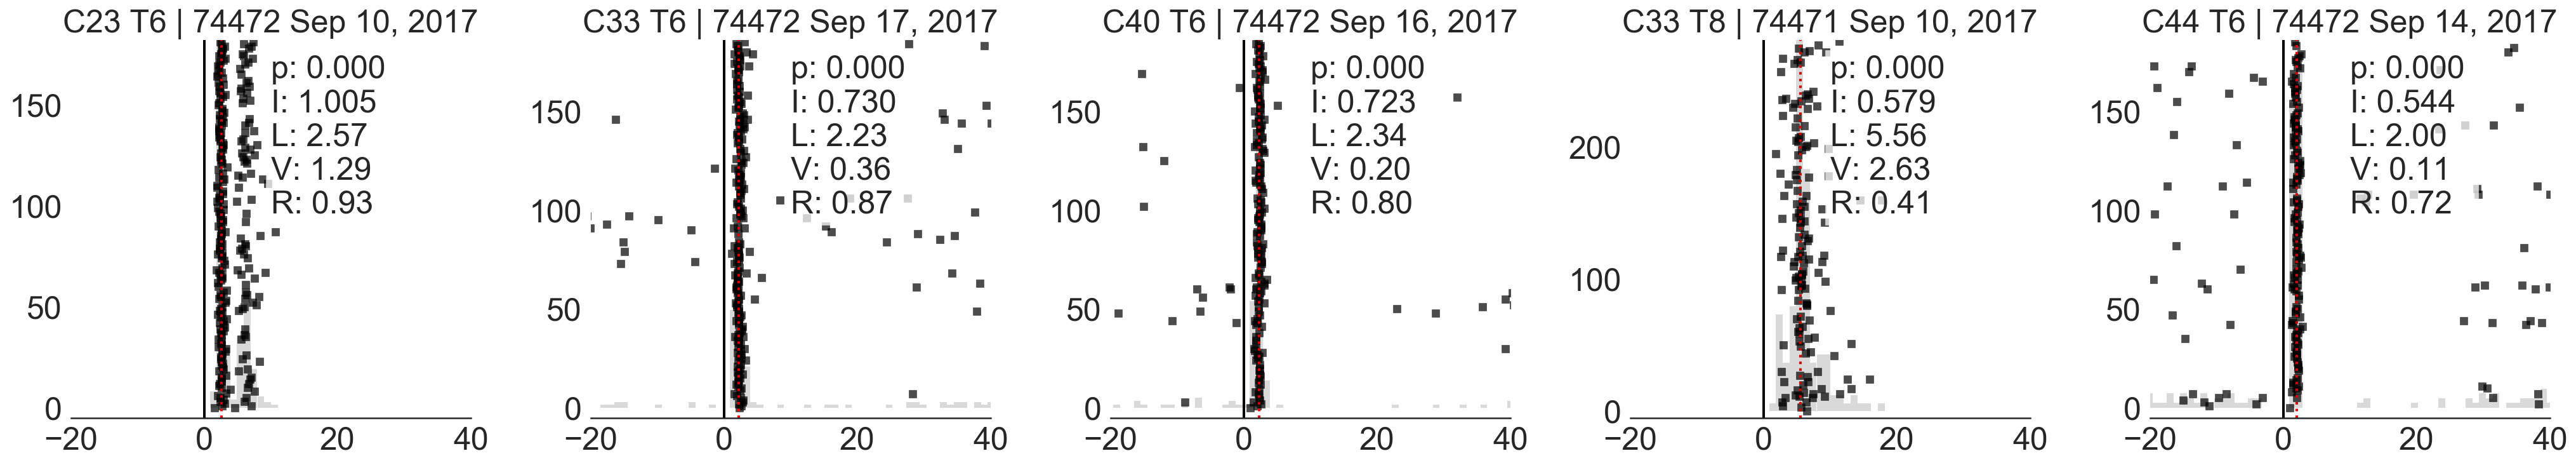

In [37]:
create_spike_plots_stimulus(data_to_draw.sort_values(by='salt_i',ascending=False),5,0,True)

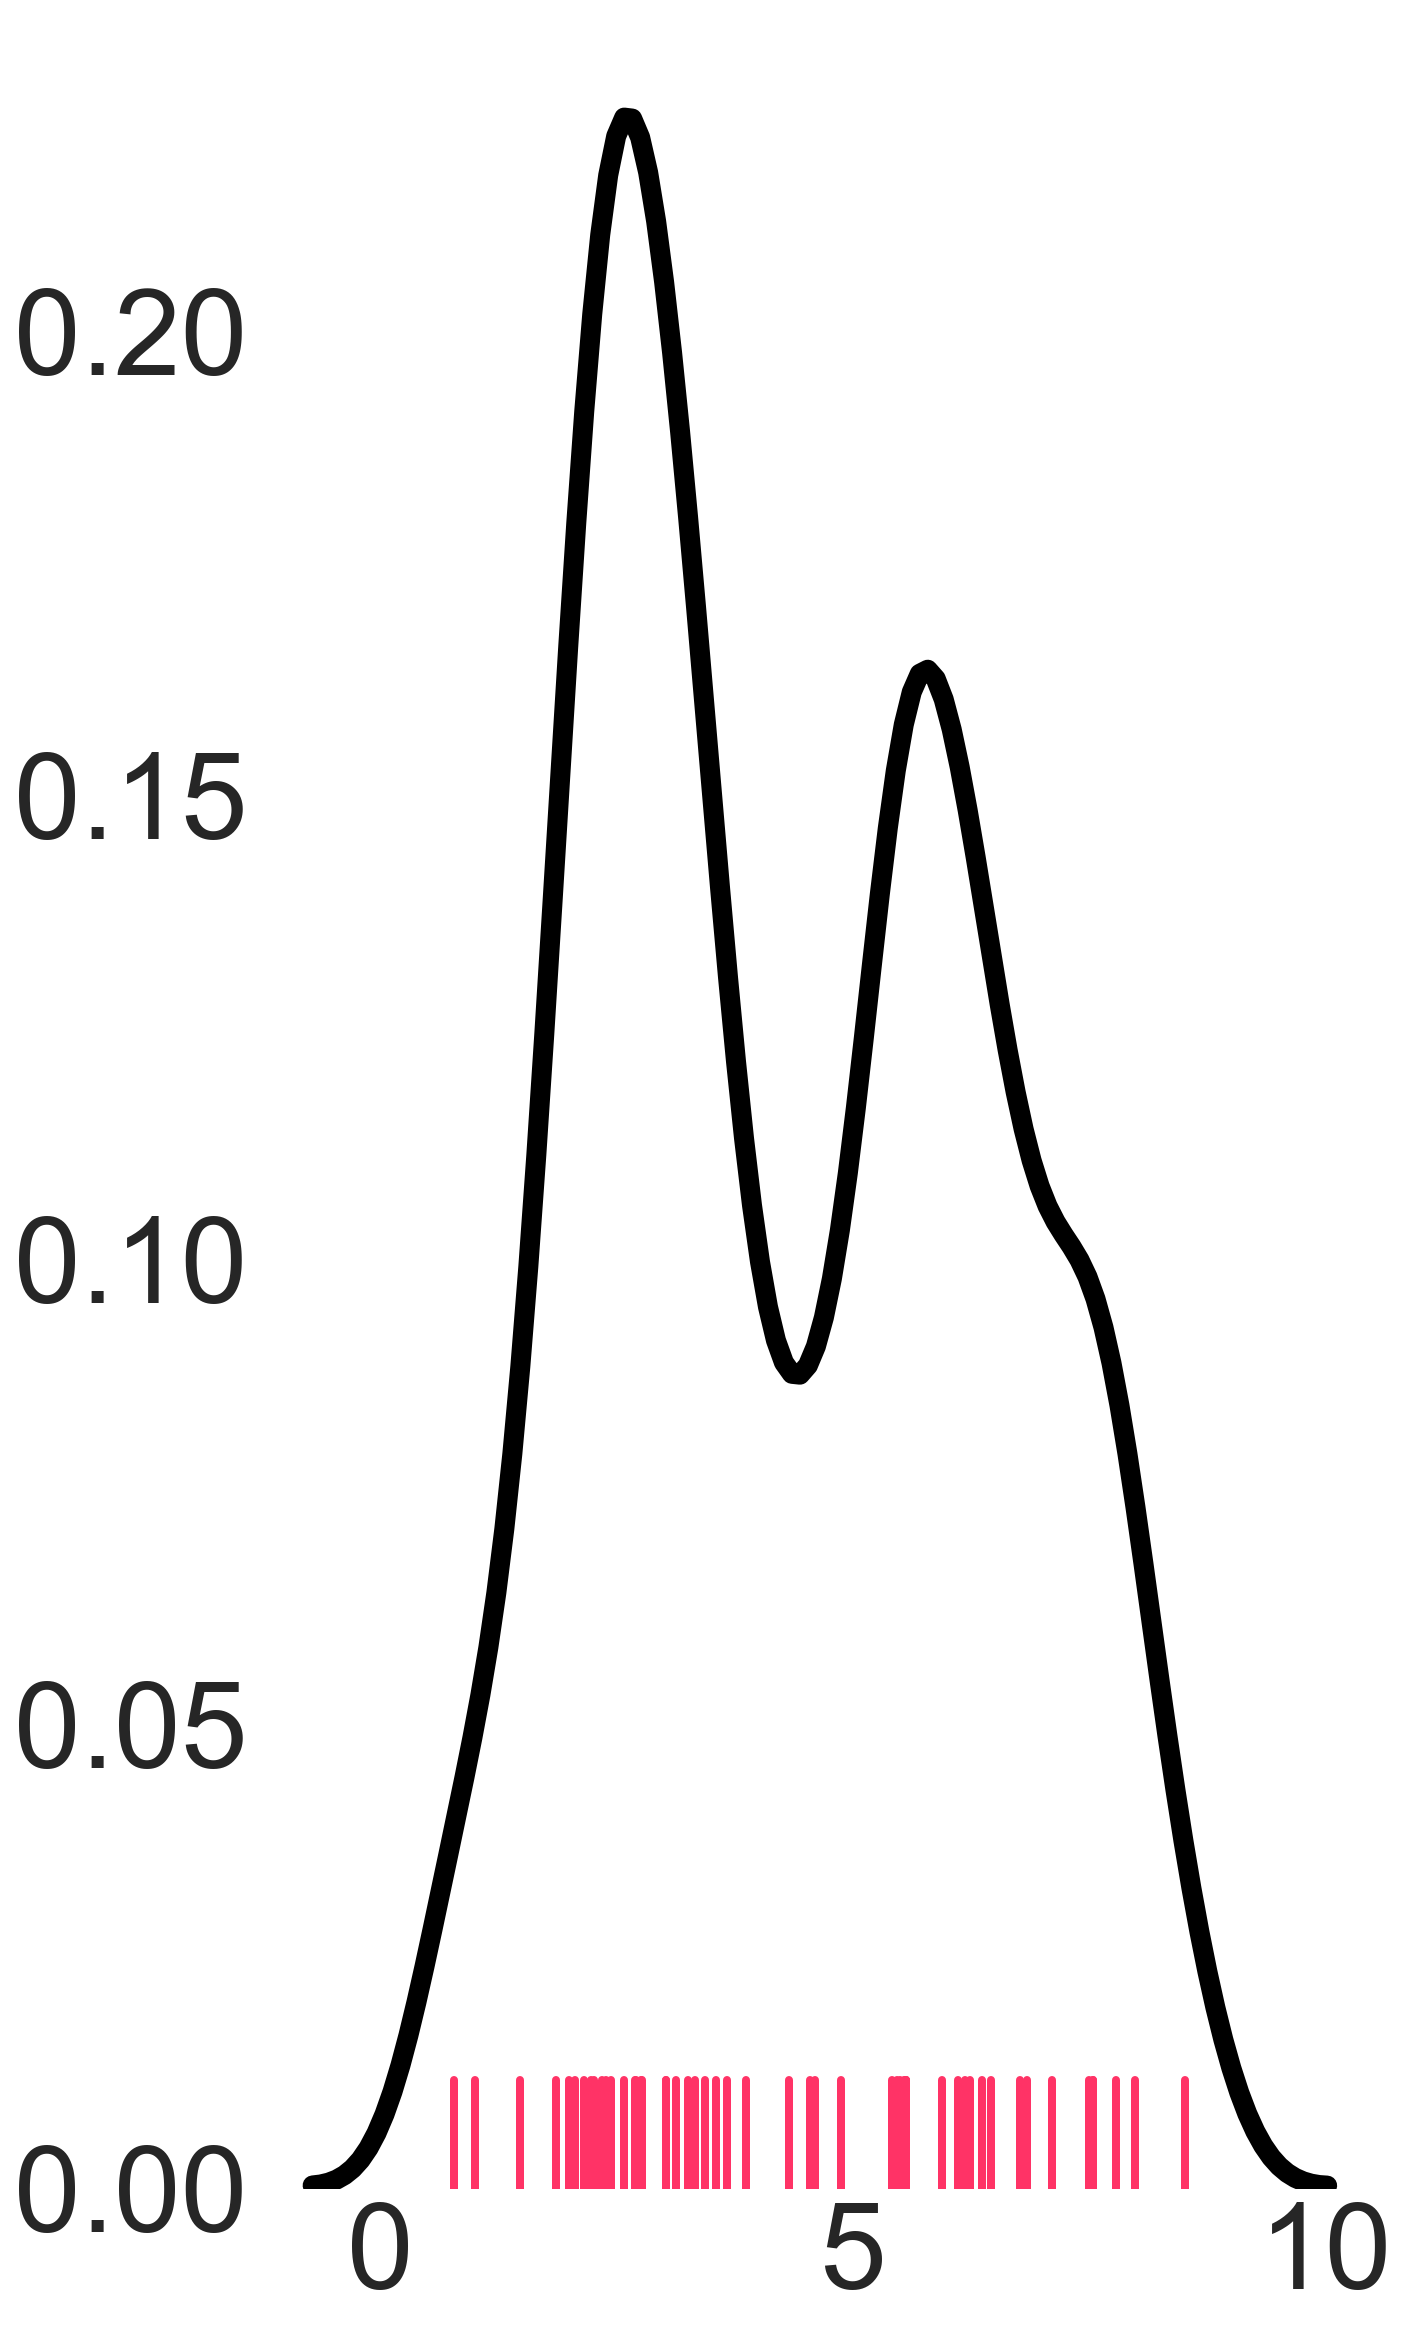

In [38]:
sns.set(font_scale=6,style='white')
figure = plt.figure(figsize=(10,20))
ax = figure.add_subplot(111)
sns.kdeplot(data_to_draw.ex_latency_median, bw=.5,color='k',ax=ax,linewidth=10)
sns.rugplot(data_to_draw.ex_latency_median,color=[1,.2,.4],ax=ax,linewidth=4)
ax.legend('')
#ax = figure.add_subplot(122)
#sns.kdeplot(data_to_draw.ex_latency_mean, bw=.5, label="Exc lat mean",color='k',ax=ax)
#sns.rugplot(data_to_draw.ex_latency_mean,color='m',ax=ax)
sns.despine(left=True,bottom=True)

Length of input dataframe: 188
Dataframe not empty


HBox(children=(IntProgress(value=0, description='Mining tables: ', max=2), HTML(value='')))

Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'analysis_window', 'salt_window', 'sample_rate', 'sample_rate_inp', 'ibi', 'stim_freq', 'stim_length', 'counter_stimuli', 'excited', 'salt_p', 'salt_i', 'ex_latency_mean', 'ex_latency_median', 'ex_latency_var', 'ex_latency_reliabil', 'stats_p_inhib_10', 'stats_p_inhib_20', 'stats_p_inhib_30', 'stats_p_inhib_40', 'inhibited', 'inhib_lowest_p', 'inhib_lowest_p_interval', 'change_point_ms')
Column filename already exists. Skipping.


HBox(children=(IntProgress(value=0, description='stimulus_tb: ', max=188), HTML(value='')))

Success. NaNs: 0
Table dictionary is empty for this entry. Taking all columns!
Included the following columns: ('analysis_ts', 'filename', 'sample_rate', 'sample_rate_inp', 'analysis_window', 'counter_stimuli', 'spiketimes_cluster', 'stimulus_timepoints', 'sum_1ms', 'bin_edges_1ms', 'binnumber_1ms')
Column analysis_ts already exists. Skipping.
Column filename already exists. Skipping.
Column sample_rate already exists. Skipping.
Column sample_rate_inp already exists. Skipping.
Column analysis_window already exists. Skipping.
Column counter_stimuli already exists. Skipping.


HBox(children=(IntProgress(value=0, description='stimulus_mat_tb: ', max=188), HTML(value='')))

Success. NaNs: 0



HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Generating plot...


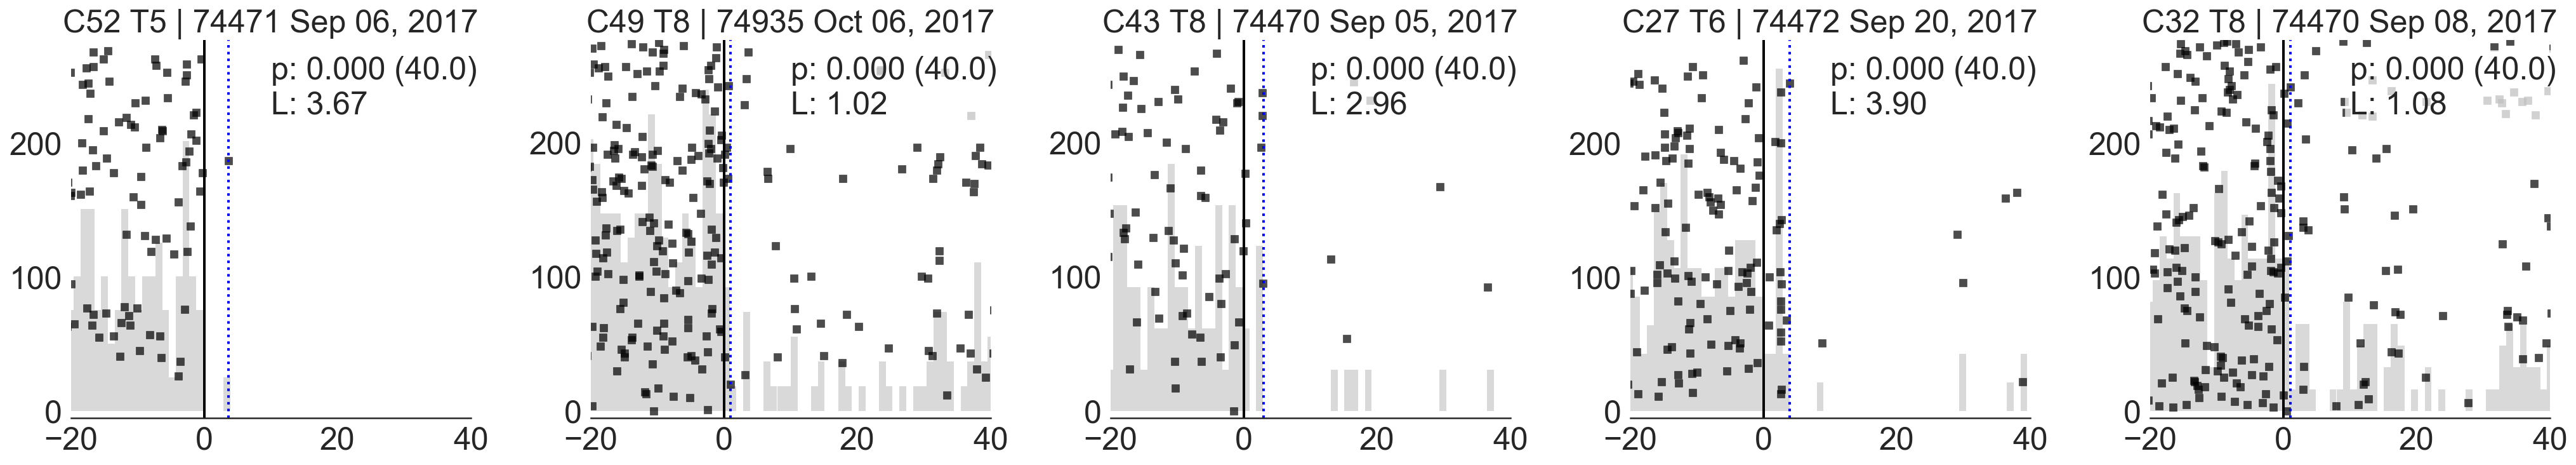

In [39]:
psql = psql_neuroballs(all_[all_.label == 'inhibited'])
dict_ = {'stimulus_tb':'','stimulus_mat_tb':''}
data_to_draw = psql.retrieve_data(dict_)
create_spike_plots_stimulus(data_to_draw.sort_values(by='inhib_lowest_p',ascending=True),5,0,True)

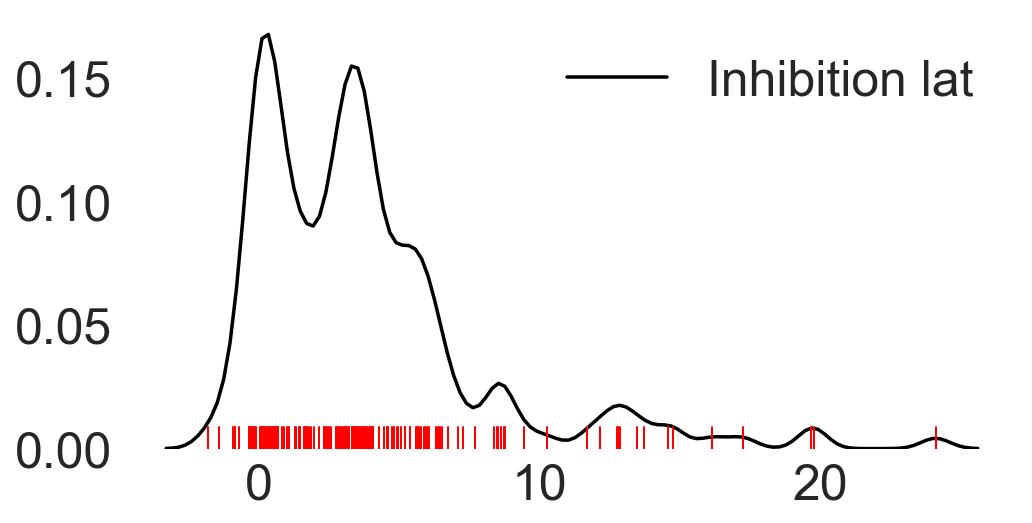

In [40]:
figure = plt.figure(figsize=(8,4))
ax = figure.add_subplot(111)
sns.kdeplot(data_to_draw.change_point_ms.dropna(), bw=0.5, label="Inhibition lat",color='k',ax=ax)
sns.rugplot(data_to_draw.change_point_ms.dropna(),color='r',ax=ax)
sns.despine(left=True,bottom=True)

In [41]:
len(data_to_draw)

188